<a href="https://colab.research.google.com/github/govind527/Interview_preparation/blob/main/Startup_Success_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective: Build a tool to help venture capital firms decide which startups to invest in.

### Data: We're using past information about startups, like when they were founded, where they are located, how many times they received funding, how much money they raised in total, how many important goals they reached, and what their current situation is (like if they are still operating, were bought, closed down, or went public).

In [ ]:
%matplotlib inline

import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
import gc
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import missingno as msno
from sklearn.model_selection import train_test_split
import statistics
#from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns

In [ ]:
objects = pd.read_csv('objects.csv')

We will focus on four main status types for companies - Operating, acquired,closed and IPO. These statuses represent the primary outcomes for startups and are most relevant for predicting the success or failure of a company.

In [ ]:
objects = objects[(objects['status']=='operating') | (objects['status']=='acquired')
                  | (objects['status']=='closed') | (objects['status']=='ipo') ]

In [ ]:
objects['status'].value_counts()

,count
status,
operating,28387
acquired,1687
closed,504
ipo,128


In [ ]:
objects.head()

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,closed_at,domain,homepage_url,twitter_username,logo_url,logo_width,logo_height,short_description,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,http://wetpaint-inc.com,BachelrWetpaint,http://s3.amazonaws.com/crunchbase_prod_assets...,401.0,54.0,NaN,Technology Platform Company,Wetpaint is a technology platform company that...,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,Seattle,Seattle,NaN,NaN,0.0,0.0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,5.0,17.0,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,NaN,flektor.com,http://www.flektor.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,186.0,85.0,NaN,NaN,Flektor is a rich-media mash-up platform that ...,"flektor, photo, video",USA,CA,Culver City,Los Angeles,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,6.0,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,NaN,there.com,http://www.there.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,107.0,34.0,NaN,NaN,There.com is an online virtual world where any...,"virtualworld, there, teens",USA,CA,San Mateo,SF Bay,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2003-02-01,2011-09-23,4.0,12.0,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,NaN,mywebbo.com,http://www.mywebbo.com,NaN,NaN,0.0,0.0,NaN,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...","social-network, new, website, web, friends, ch...",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,NaN,themoviestreamer.com,http://themoviestreamer.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,200.0,74.0,NaN,NaN,This company shows free movies online on their...,"watch, full-length, moives, online, for, free,...",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18


We are focusing on startups to understand the factors contributing to their success or failure, which is the main objective of this analysis. Other entity types like private equity funds or individuals are not directly relevant to this goal.

In [ ]:
objects = objects[objects['entity_type']=='Company']

In [ ]:
objects.shape

(30706, 40)

In [ ]:
objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30706 entries, 0 to 30705
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   30706 non-null  object 
 1   entity_type          30706 non-null  object 
 2   entity_id            30706 non-null  int64  
 3   parent_id            0 non-null      float64
 4   name                 30705 non-null  object 
 5   normalized_name      30706 non-null  object 
 6   permalink            30706 non-null  object 
 7   category_code        23014 non-null  object 
 8   status               30706 non-null  object 
 9   founded_at           18809 non-null  object 
 10  closed_at            518 non-null    object 
 11  domain               23630 non-null  object 
 12  homepage_url         23629 non-null  object 
 13  twitter_username     16561 non-null  object 
 14  logo_url             21820 non-null  object 
 15  logo_width           30705 non-null 

Dropping features such as created_at, updated_at which are just meta data that will not help with the analysis

In [ ]:
df = objects.drop(['updated_at','created_at','created_by','logo_height','logo_width','logo_url','twitter_username',
             'homepage_url','domain','permalink','name','parent_id'],axis=1)

In [ ]:
df.head()

,id,entity_type,entity_id,normalized_name,category_code,status,founded_at,closed_at,short_description,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships
0,c:1,Company,1,wetpaint,web,operating,2005-10-17,NaN,NaN,Technology Platform Company,Wetpaint is a technology platform company that...,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,Seattle,Seattle,NaN,NaN,0.0,0.0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,5.0,17.0
1,c:10,Company,10,flektor,games_video,acquired,NaN,NaN,NaN,NaN,Flektor is a rich-media mash-up platform that ...,"flektor, photo, video",USA,CA,Culver City,Los Angeles,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,6.0
2,c:100,Company,100,there,games_video,acquired,NaN,NaN,NaN,NaN,There.com is an online virtual world where any...,"virtualworld, there, teens",USA,CA,San Mateo,SF Bay,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2003-02-01,2011-09-23,4.0,12.0
3,c:10000,Company,10000,mywebbo,network_hosting,operating,2008-07-26,NaN,NaN,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...","social-network, new, website, web, friends, ch...",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0
4,c:10001,Company,10001,the movie streamer,games_video,operating,2008-07-26,NaN,NaN,NaN,This company shows free movies online on their...,"watch, full-length, moives, online, for, free,...",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0


Visualizing the missing values in the remaining features to make decisions on which other features can be dropped. closed_at only has mostly has empty values so it may not be a useful predictor in our model. Short description is also predominantly empty and can be dropped.

<Axes: >

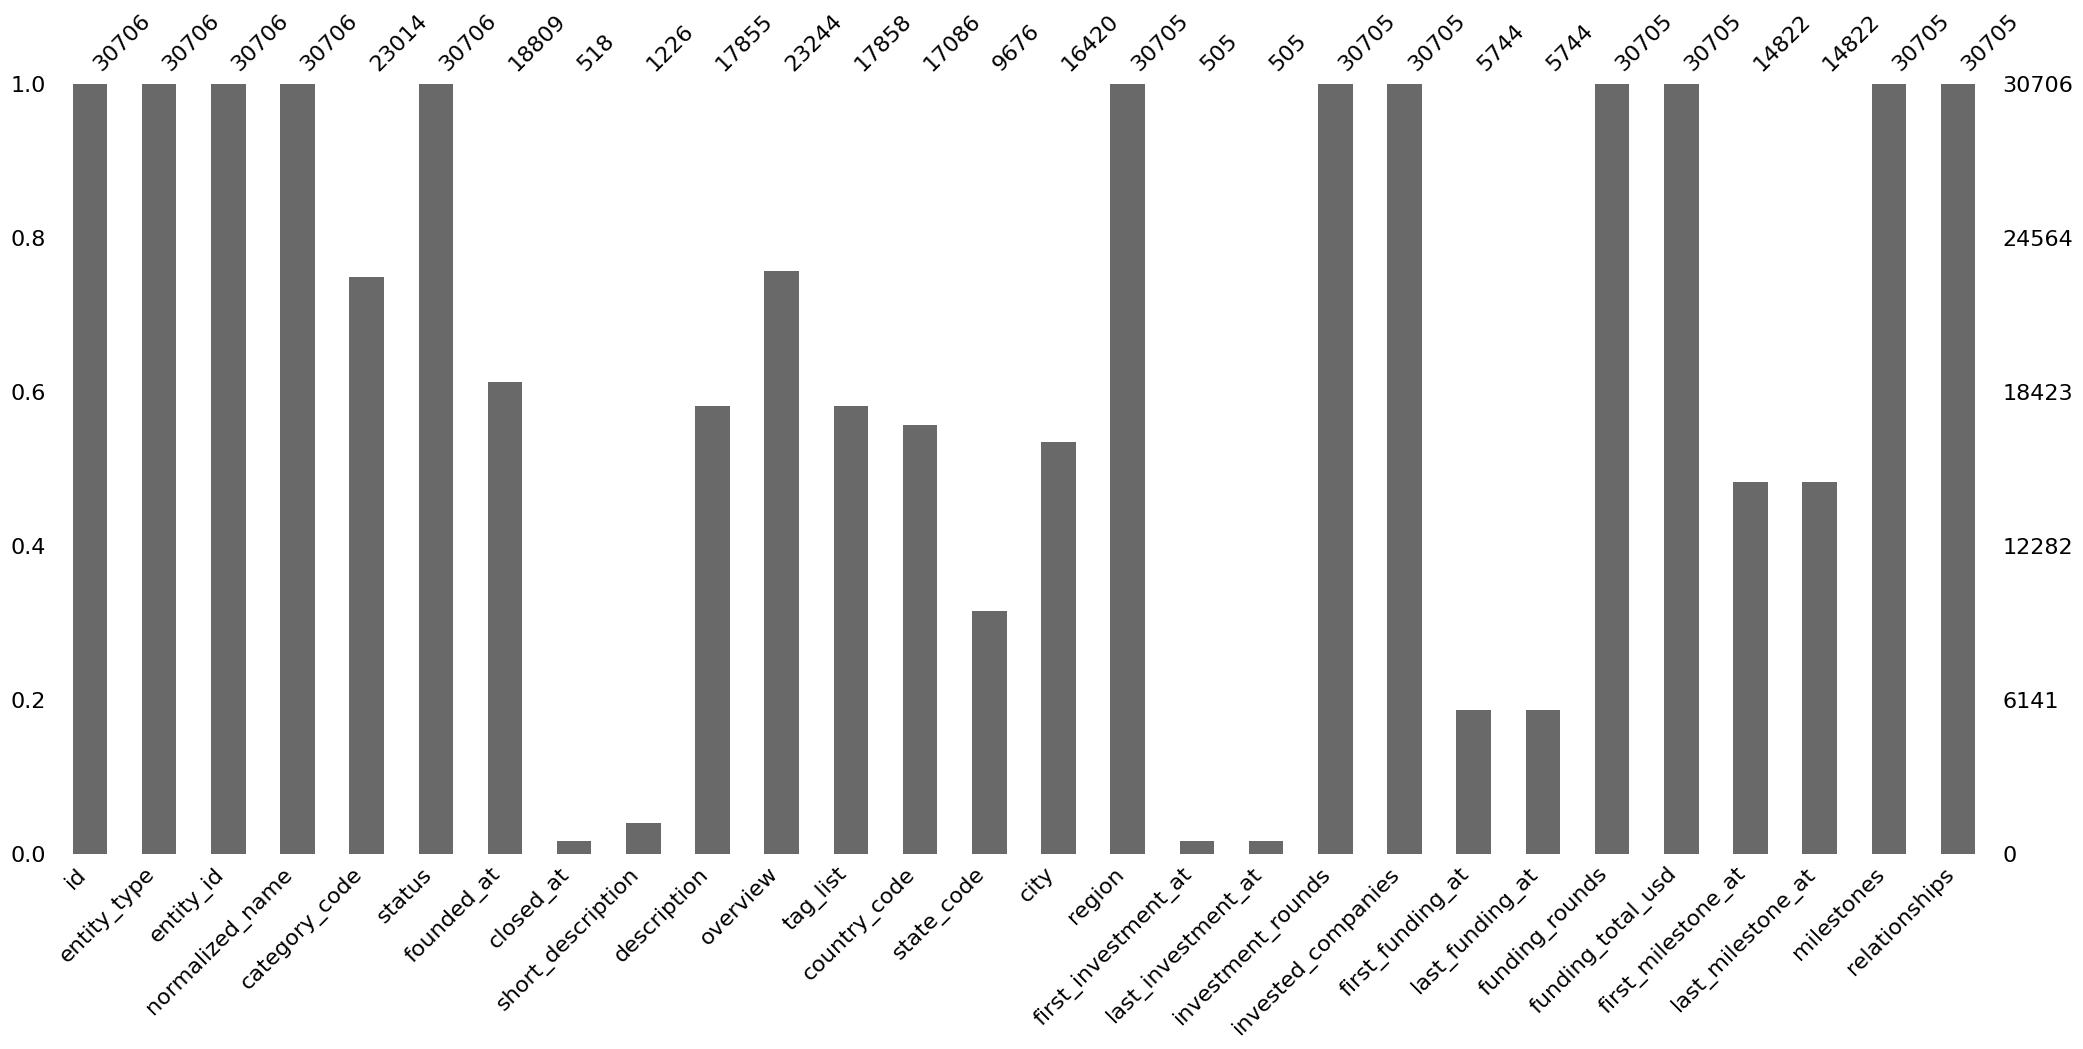

In [ ]:
msno.bar(df)

In [ ]:
df = df.drop(['short_description','closed_at'],axis=1)

In [ ]:
df.head()

,id,entity_type,entity_id,normalized_name,category_code,status,founded_at,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships
0,c:1,Company,1,wetpaint,web,operating,2005-10-17,Technology Platform Company,Wetpaint is a technology platform company that...,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,Seattle,Seattle,NaN,NaN,0.0,0.0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,5.0,17.0
1,c:10,Company,10,flektor,games_video,acquired,NaN,NaN,Flektor is a rich-media mash-up platform that ...,"flektor, photo, video",USA,CA,Culver City,Los Angeles,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,6.0
2,c:100,Company,100,there,games_video,acquired,NaN,NaN,There.com is an online virtual world where any...,"virtualworld, there, teens",USA,CA,San Mateo,SF Bay,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2003-02-01,2011-09-23,4.0,12.0
3,c:10000,Company,10000,mywebbo,network_hosting,operating,2008-07-26,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...","social-network, new, website, web, friends, ch...",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0
4,c:10001,Company,10001,the movie streamer,games_video,operating,2008-07-26,NaN,This company shows free movies online on their...,"watch, full-length, moives, online, for, free,...",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0


Important variables for analysis - category_code, country_code, state_code, investment_rounds, invested_companies, funding_rounds, funding_total_usd, milestones, relationships. The target variable is status



Understanding the category_code feature - The top 20 most popular startup types are as follows. Software, web, ecommerce are the most popular.

<Axes: ylabel='category_code'>

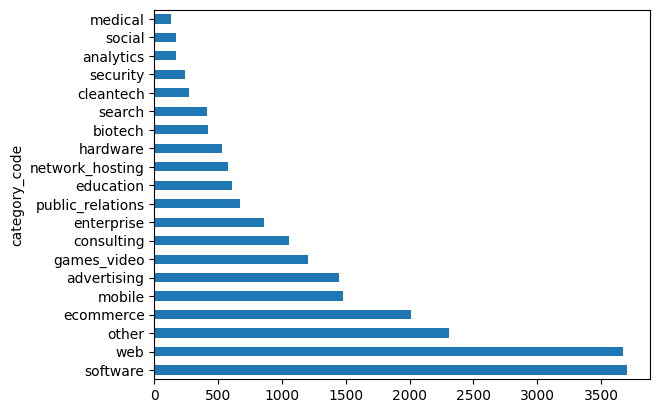

In [ ]:
df['category_code'].value_counts()[0:20].plot(kind='barh')

Which category has the most failed startups?

In [ ]:
temp = df[df['status']=='closed']

The failure trend seems to follow the frequency of startups as the most failures are in the industries with the most start up. This makes sense as there might be immense competition in these categories, making it hard for startups to differentiate themselves and find a niche that allows them to leverage their core competence.

<Axes: ylabel='category_code'>

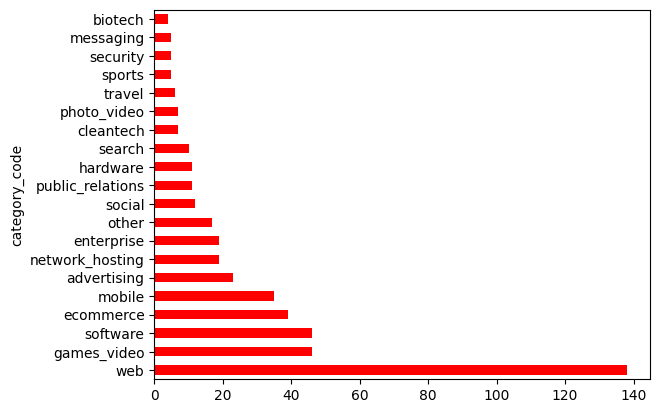

In [ ]:
temp['category_code'].value_counts()[0:20].plot(kind='barh',color='red')

Which category has the most IPO's? Biotech appears to be the most lucrative space as it has a significantly higher number of IPO's even though there are fewer total startups in the space.

In [ ]:
temp = df[df['status']=='ipo']

<Axes: ylabel='category_code'>

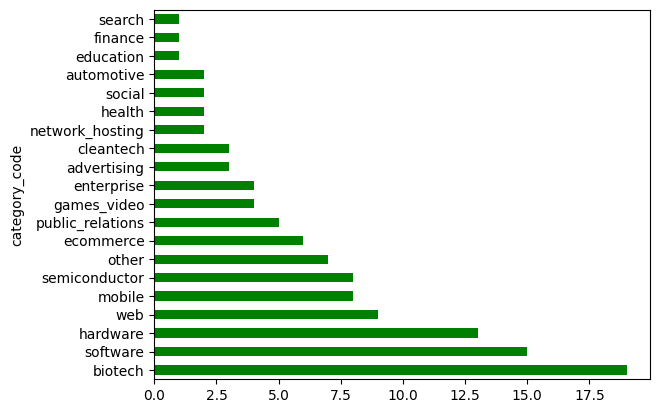

In [ ]:
temp['category_code'].value_counts()[0:20].plot(kind='barh',color='green')

In [ ]:
temp = df[df['status']=='closed']
temp2 = df[df['status']=='operating']

In [ ]:
category_failure = temp.groupby('category_code')['status'].count()

In [ ]:
category_operating = temp2.groupby('category_code')['status'].count()

In [ ]:
failure_rate_by_cat = (category_failure/category_operating)*100

In [ ]:
tempdf= pd.DataFrame({'category_code':failure_rate_by_cat.index, 'ratio':failure_rate_by_cat.values})

Understanding failure rate by industry. security, advertising, music and analytics seem to have the highest failure rate. Understanding failure rate by industry helps us identify sectors where startups face greater challenges. This analysis can inform entrepreneurs about potential risks and opportunities when choosing an industry, and provide insights into market dynamics and competitive landscapes.

In [ ]:
t = tempdf[tempdf['ratio']>0]
t= t.sort_values(by='ratio')[0:20]

<Axes: xlabel='category_code'>

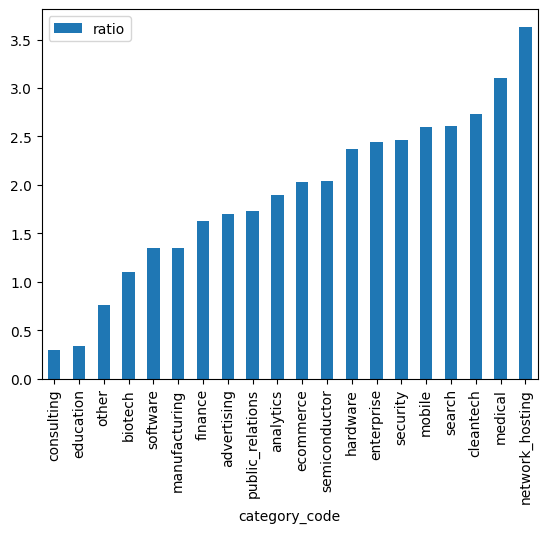

In [ ]:
t.plot.bar(x='category_code',y='ratio')

Understanding country code feature - most startups (atleast in this database) are founded/predominantly operated in the USA. GBR and IND are second and third but are behind by quite a margin

<Axes: ylabel='country_code'>

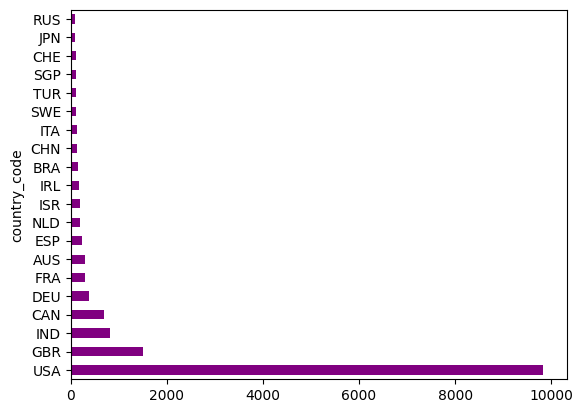

In [ ]:
df['country_code'].value_counts()[0:20].plot(kind='barh',color='purple')

Understanding the distribution for milestone,relationships,funding_rounds and investment_rounds, which are numerical variables

In [ ]:
num_var = ['milestones','relationships','funding_rounds','investment_rounds']

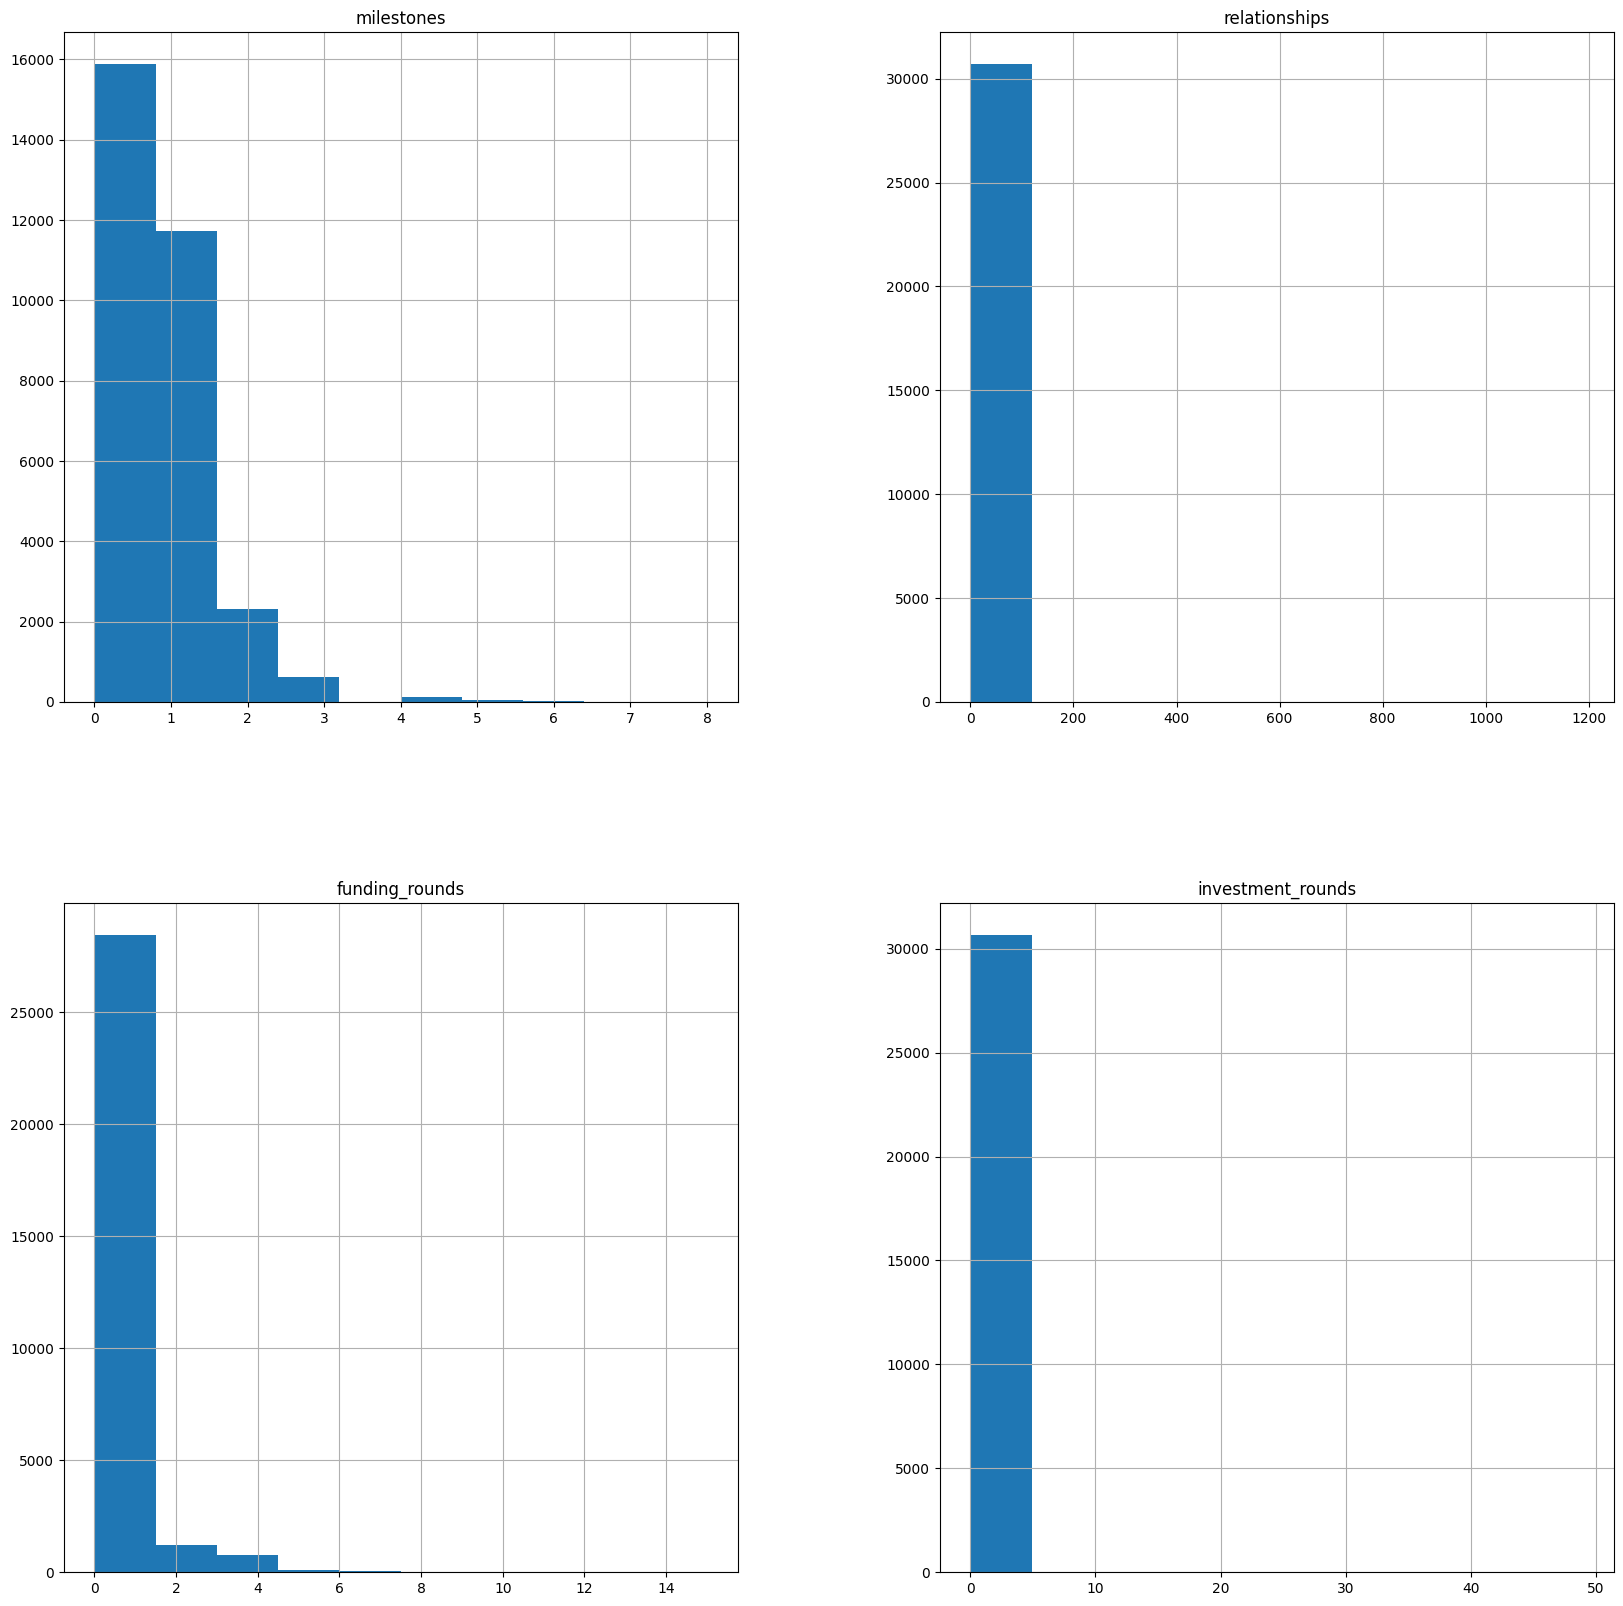

In [ ]:
plots = df[num_var].hist(figsize=(20,20))

milestones and funding rounds seem left skewed so we can use box cox transformation to normalize those features

In [ ]:
df['funding_rounds'].value_counts()

,count
funding_rounds,
0.0,24918
1.0,3559
2.0,1226
3.0,533
4.0,247
5.0,113
6.0,49
7.0,27
8.0,14


Does the mean funding rounds change for successful vs unsuccessful statups? Interestingly, operating and acquired companies had a lower mean value than closed/IPO start ups. This suggests that funding rounds can have a very extreme impact on the trajectory on a startup. The influx in cash can either really help a company succeed and breakout. Or it can also result in mismanagement and extreme unsustainable growth that can cause start ups to fail


In [ ]:
df.groupby('status')['funding_rounds'].mean()

,funding_rounds
status,
acquired,0.553053
closed,1.095238
ipo,1.679688
operating,0.290671


Do relationships affect the trajectory of a startup? There is a huge gap between all the categories and IPO. This really emphasizes how difficult it is to get a startup to the IPO phase and shows the importance of relationships in different areas to make this happen as it is a huge collaborative effort. The mean relationships for acquisitions is also higher than operating or closed.

<Axes: xlabel='status'>

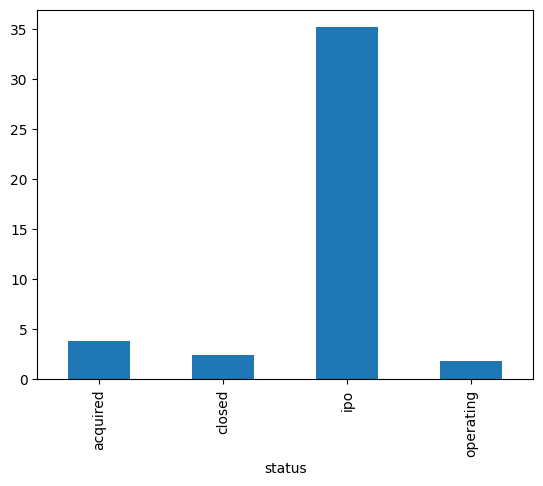

In [ ]:
df.groupby('status')['relationships'].mean().plot(kind='bar')

Preparing the features for the model -  First we will transform the categorical variables using label encoding. We chose to use label encoding instead of one hot encoding as there were alot of categories for each categorical variable. If we used one hot encoding, we would have too many features to look at

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['category_code_enc'] = le.fit_transform(df['category_code'])
df['country_code_enc'] = le.fit_transform(df['country_code'])
df['state_code_enc'] = le.fit_transform(df['state_code'])


We have to normalize the numerical variables as these features have very different magnitudes and at present we don't know if any variable is more important than the other so we do not want to weight features differently.

In [ ]:
num_vars = ['investment_rounds','invested_companies','funding_rounds','funding_total_usd','milestones','relationships']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

Important variables for analysis - category_code, country_code, state_code, investment_rounds, invested_companies, funding_rounds, funding_total_usd, milestones, relationships. The target variable is status

Creating the target variable for prediction -

success = 1 -> IPO, operating, acquired

failure = 0 -> closed

In [ ]:
df['status_enc'] = df['status'].apply(lambda x: 1 if ((x=="ipo")|(x=="acquired")|(x=="operating") ) else 0)

In [ ]:
df.status_enc.value_counts()

,count
status_enc,
1,30202
0,504


After encoding, we can see that we have a highly imbalanced data set. The majority class is sucessful while the minority class is failed startups. In order to deal with this imbalance, we will use random oversampling and SMOTE

Option1: Random Sampling

In [ ]:
df.columns

Index(['id', 'entity_type', 'entity_id', 'normalized_name', 'category_code',
       'status', 'founded_at', 'description', 'overview', 'tag_list',
       'country_code', 'state_code', 'city', 'region', 'first_investment_at',
       'last_investment_at', 'investment_rounds', 'invested_companies',
       'first_funding_at', 'last_funding_at', 'funding_rounds',
       'funding_total_usd', 'first_milestone_at', 'last_milestone_at',
       'milestones', 'relationships', 'category_code_enc', 'country_code_enc',
       'state_code_enc', 'status_enc'],
      dtype='object')

In [ ]:
X = df.drop(['id','entity_type','entity_id','normalized_name','status','founded_at','description',
            'overview','tag_list','country_code', 'state_code', 'city', 'region', 'first_investment_at',
       'last_investment_at','first_funding_at', 'last_funding_at','first_milestone_at', 'last_milestone_at','status_enc','category_code'],axis=1)

y = df['status_enc']

# Impute missing values in X after dropping columns but before applying SMOTE
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns) # Convert back to DataFrame to keep column names

In [ ]:
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_rand, y_rand = ros.fit_resample(X, y)

Option2: SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

Splitting the balanced data into test and train to begin building machine learning models

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote , train_size=0.7, test_size=0.3, random_state=42)

Building a base model - Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42,solver='saga',max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
!pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 39.1 MB/s eta 0:00:00


In [ ]:
import dmba
from sklearn.metrics import accuracy_score

print(logreg.__class__.__name__, accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__, dmba.classificationSummary(y_test, y_pred))


Colab environment detected.
LogisticRegression 0.8085200309016665
Confusion Matrix (Accuracy 0.8085)

       Prediction
Actual    0    1
     0 7051 2045
     1 1425 7601
LogisticRegression None


In [ ]:
pd.set_option('display.max_rows', None)
feature_imp = logreg.coef_
coef_table = pd.DataFrame({"feature_names":X_train.columns,"Beta":feature_imp[0],"AbsBeta":abs(feature_imp[0])})

coef_table =coef_table.sort_values(by = "AbsBeta",ascending=False)
coef_table

,feature_names,Beta,AbsBeta
3,funding_total_usd,2.233442,2.233442
2,funding_rounds,-1.618226,1.618226
5,relationships,1.488903,1.488903
0,investment_rounds,0.204753,0.204753
1,invested_companies,0.165340,0.165340
4,milestones,-0.139946,0.139946
8,state_code_enc,0.014441,0.014441
6,category_code_enc,-0.004333,0.004333
7,country_code_enc,0.002732,0.002732


Using GridSearchCV, we were able to very slightly increase accuracy of the model. We found that using an l1 penalty instead of the default l2 penalty provided better results

In [ ]:
from sklearn.model_selection import GridSearchCV

log_para = {'C':list(range(1,10)),'penalty':['l1','l2','elasticnet'] }
clf1 = GridSearchCV(logreg, log_para, cv=5, n_jobs=-1)

In [ ]:
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
print(clf1.__class__.__name__, accuracy_score(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1203, in fit
    raise ValueError("l1_

GridSearchCV 0.808575212448957


In [ ]:
clf1.best_params_

{'C': 2, 'penalty': 'l1'}

Checking if above C really the best parameter by using smaller increments of C


In [ ]:
from scipy.stats import reciprocal, uniform
C_options= list(np.arange(1, 2,0.1))

log_para = {'C':C_options}
logreg2 = LogisticRegression(random_state=42,solver='saga',max_iter=1000,penalty='l1')
clf2 = GridSearchCV(logreg2, log_para, cv=5, n_jobs=-1)


In [ ]:
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print(clf2.__class__.__name__, accuracy_score(y_test, y_pred))

GridSearchCV 0.808575212448957


In [ ]:
clf2.best_params_

{'C': np.float64(1.7000000000000006)}

Checking to see if using random oversampling data provides better results than SMOTE

In [ ]:
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_rand,y_rand , train_size=0.7, test_size=0.3, random_state=42)

In [ ]:
logreg = LogisticRegression(random_state=42,solver='saga',max_iter=1000,penalty='l1')
logreg.fit(X_train_2, y_train_2)
y_pred = logreg.predict(X_test_2)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(logreg.__class__.__name__, accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__, dmba.classificationSummary(y_test, y_pred))

LogisticRegression 0.7913585696942942
Confusion Matrix (Accuracy 0.7914)

       Prediction
Actual    0    1
     0 6811 2285
     1 1496 7530
LogisticRegression None


TAKEAWAY FROM LOGISTIC REGRESSION: It appears that SMOTE results in better performance than random oversampling. Also, adding a penalty=l2 instead of the default also increases performance.

Running backward selection on the features to see whether a subset of features would improve performance of the model, using the best parameters found using GridSearchCV

In [ ]:
features = ['category_code_enc','country_code_enc','state_code_enc','milestones',
            'invested_companies','investment_rounds','funding_total_usd',
           'relationships','funding_rounds']

Model 2: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(random_state=42)
rfclf.fit(X_train, y_train)
y_pred = rfclf.predict(X_test)

In [ ]:
print(rfclf.__class__.__name__, accuracy_score(y_test, y_pred))
print(rfclf.__class__.__name__, dmba.classificationSummary(y_test, y_pred))

RandomForestClassifier 0.9758304822867233
Confusion Matrix (Accuracy 0.9758)

       Prediction
Actual    0    1
     0 8735  361
     1   77 8949
RandomForestClassifier None


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rfclf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfclf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.024 seconds


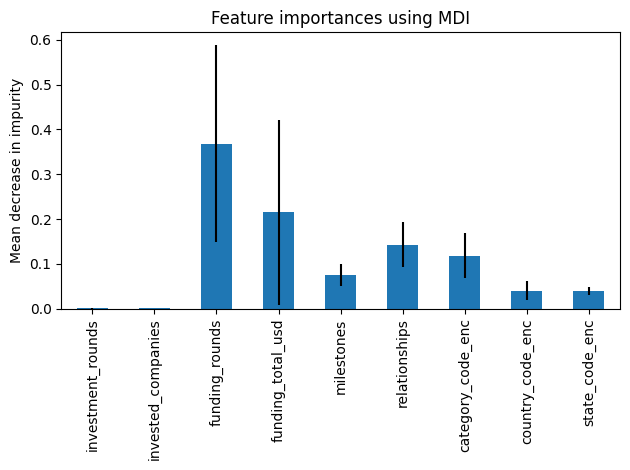

In [ ]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

RandomForests offer more accuracy than logistic regression. According to the model, funding_rounds, total_funding and relationships are the three most important features on the basis of mean decrease in impurity. This is the same top 3 in the logistic regression model, however, the logistic model gave more importance to relationships than funding_total

Model 3: SVC - LinearSVC performs very poorly as compared to the other models so we will remove it from the VotingClassifier

In [ ]:
from sklearn.svm import LinearSVC
svcclf = LinearSVC(random_state=0, tol=1e-5)
svcclf.fit(X_train, y_train)
y_pred = svcclf.predict(X_test)

In [ ]:
print(svcclf.__class__.__name__, accuracy_score(y_test, y_pred))
print(svcclf.__class__.__name__, dmba.classificationSummary(y_test, y_pred))

LinearSVC 0.8010705220174373
Confusion Matrix (Accuracy 0.8011)

       Prediction
Actual    0    1
     0 6907 2189
     1 1416 7610
LinearSVC None


Now that we have tried RandomForests, Logistic Regression models and SVC on their own, we will now look at some ensemble approachs to improving the overall performance of the model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42,solver='saga',max_iter=1000,penalty='l1')
rnd_clf = RandomForestClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf)],
    voting='soft')


In [ ]:
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)


Using a voting classifier with logreg and randomforests gives better performance than just a logistic regression. However, the accuracy is lower than what we achieved by just using the randomforest model

In [ ]:
print(voting_clf.__class__.__name__, accuracy_score(y_test, y_pred))
print(voting_clf.__class__.__name__, dmba.classificationSummary(y_test, y_pred))

VotingClassifier 0.9541993157488136
Confusion Matrix (Accuracy 0.9542)

       Prediction
Actual    0    1
     0 8762  334
     1  496 8530
VotingClassifier None


The baggingclassifier also did not increase the performance of the random forest model

In [ ]:
from sklearn.ensemble import BaggingClassifier


bag_clf = BaggingClassifier(
    RandomForestClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)



In [ ]:
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.8589559651252621


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.9107162564838318
